In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# FIT5226 Project Stage 1 - Tabular Q-Learning for Single Agent

This notebook implements a tabular Q-learning algorithm to train an agent to complete a transport task in a grid world environment. The agent's goal is to pick up an item at location A and deliver it to location B with the fewest steps possible.

# FIT5226 Project Stage 1 - Tabular Q-Learning for Single Agent

## Task 1: Reward Structure

The reward structure is designed to effectively guide the agent in learning the task of picking up an item at location A and delivering it to location B within a grid world. The rewards and penalties are structured as follows:

- **Step Penalty (`-1`)**: The agent receives a small negative reward for each step it takes. This encourages the agent to find the shortest path to complete the task.

- **Boundary Penalty (`-5`)**: If the agent attempts to move outside the grid boundaries, it receives a larger negative reward. This penalty prevents the agent from making invalid moves.

- **Moving Away Penalty (`-2`)**: 
  - Before picking up the item at location A, if the agent moves away from A, it receives a negative reward.
  - After picking up the item, if the agent moves away from the goal location B, it also receives a negative reward. This encourages the agent to stay focused on reaching its goals.

- **Item Pickup Reward (`+10`)**: When the agent successfully reaches location A and picks up the item, it receives a positive reward. This reward reinforces the importance of picking up the item.

- **Goal Completion Reward (`+50`)**: The agent receives a large positive reward for successfully delivering the item to location B, completing the task. This reward signifies the successful completion of the agent's mission.

This reward structure is intended to incentivize efficient and goal-directed behavior, ensuring that the agent learns to complete the task with the minimum number of steps while avoiding unnecessary or invalid movements.

## Task 2: GridWorld Environment

In this task, we implement the `GridWorld` environment where the agent will operate. The environment is a square grid of size `n x n`. The agent's goal is to pick up an item at location A and deliver it to a fixed target location B, which is the bottom-right corner of the grid.

The environment includes:
- A grid of configurable size.
- An agent that can move in four directions: north, south, east, and west.
- An item that the agent must pick up at a randomly placed location A.
- A goal location B where the agent must deliver the item.

The `GridWorld` class manages the environment's state, allows the agent to take actions, and provides feedback in the form of rewards and state transitions.

In [2]:
class GridWorld:
    def __init__(self, size=5, start=None, item_location=None, goal_location=None):
        # Initialization of the environment
        self.size = size
        self.start = start if start else (0, 0)
        self.item_location = item_location if item_location else (size//2, size//2)
        self.goal_location = goal_location if goal_location else (size-1, size-1)
        self.agent_position = self.start
        self.has_item = False

    def reset(self):
        """Resets the environment to the initial state."""
        self.agent_position = self.start
        self.has_item = False
        return self.get_state()

    def get_state(self):
        """Returns the current state of the environment."""
        return (self.agent_position, self.item_location, self.has_item)

    def step(self, action):
        """Executes an action and updates the environment."""
        # Code for agent movement, reward calculation, and state update
        if action == 'north' and self.agent_position[0] > 0:
            self.agent_position = (self.agent_position[0] - 1, self.agent_position[1])
        elif action == 'south' and self.agent_position[0] < self.size - 1:
            self.agent_position = (self.agent_position[0] + 1, self.agent_position[1])
        elif action == 'east' and self.agent_position[1] < self.size - 1:
            self.agent_position = (self.agent_position[0], self.agent_position[1] + 1)
        elif action == 'west' and self.agent_position[1] > 0:
            self.agent_position = (self.agent_position[0], self.agent_position[1] - 1)

        if self.agent_position == self.item_location:
            self.has_item = True

        done = False
        if self.agent_position == self.goal_location and self.has_item:
            reward = 50
            done = True
        else:
            reward = -1

        if not done and self.agent_position == self.item_location and not self.has_item:
            reward = 10

        next_state = self.get_state()
        return next_state, reward, done

## Task 3: Q-Learning Agent

In this task, we implement the Q-learning algorithm that enables the agent to learn from its interactions with the environment. The Q-learning agent uses a table to store Q-values, which represent the expected future rewards for each state-action pair.

Key components of the Q-learning agent:
- **Q-Table**: Stores the Q-values for all state-action pairs.
- **Learning Rate (`alpha`)**: Controls how much new information overrides old information.
- **Discount Factor (`gamma`)**: Reflects how much future rewards are valued compared to immediate rewards.
- **Exploration Rate (`epsilon`)**: Balances exploration (trying new actions) and exploitation (using known actions with high rewards).

The agent learns by updating its Q-values based on the rewards received and the best future Q-values it can expect.

In [3]:
import numpy as np
import random

class QLearningAgent:
    def __init__(self, alpha=0.1, gamma=0.9, epsilon=0.1, grid_size=5):
        """Initializes the Q-learning agent."""
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.grid_size = grid_size
        self.actions = ['north', 'south', 'east', 'west']

    def get_q_value(self, state, action):
        """Returns the Q-value for a given state-action pair."""
        return self.q_table.get((state, action), 0.0)

    def set_q_value(self, state, action, value):
        """Sets the Q-value for a given state-action pair."""
        self.q_table[(state, action)] = value

    def choose_action(self, state):
        """Chooses an action based on the epsilon-greedy policy."""
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(self.actions)
        else:
            q_values = [self.get_q_value(state, action) for action in self.actions]
            max_q = max(q_values)
            return self.actions[q_values.index(max_q)]

    def update_q_value(self, state, action, reward, next_state):
        """Updates the Q-value based on the received reward and next state."""
        next_q_values = [self.get_q_value(next_state, a) for a in self.actions]
        best_next_q = max(next_q_values)
        old_q_value = self.get_q_value(state, action)
        new_q_value = old_q_value + self.alpha * (reward + self.gamma * best_next_q - old_q_value)
        self.set_q_value(state, action, new_q_value)

## Task 4: Training the Agent

In this task, we train the Q-learning agent by allowing it to interact with the `GridWorld` environment over multiple episodes. During each episode, the agent starts at a random position, attempts to pick up the item at location A, and deliver it to location B.

The training process involves:
- The agent taking actions based on its current policy (exploration vs. exploitation).
- Receiving rewards based on the outcomes of its actions.
- Updating the Q-values to improve future decisions.

The training continues over a large number of episodes, enabling the agent to learn an optimal policy that minimizes the number of steps needed to complete the task.

In [4]:
def train_agent(agent, environment, episodes=1000):
    """Trains the Q-learning agent."""
    for episode in range(episodes):
        state = environment.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            agent.update_q_value(state, action, reward, next_state)
            state = next_state
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1} completed.")

## Task 5: Testing the Agent

After training, it is important to test the Q-learning agent to evaluate its performance. Testing involves running the agent in the `GridWorld` environment under different scenarios to see how well it has learned the task.

The testing process includes:
- Running the agent for a number of trials starting from different positions.
- Measuring how many steps the agent takes to complete the task.
- Calculating the success rate, which indicates how often the agent successfully completes the task.

These metrics help us assess the effectiveness of the training and the agent's ability to generalize its learned policy to new situations.

In [5]:
def test_agent(agent, environment, trials=100):
    """Tests the Q-learning agent after training."""
    total_steps = 0
    for trial in range(trials):
        state = environment.reset()
        done = False
        steps = 0
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
            steps += 1
        total_steps += steps
    average_steps = total_steps / trials
    print(f"Average steps taken: {average_steps}")
    return average_steps

## Task 6: Visualization of Agent's Path

Visualization is a crucial step in understanding how the Q-learning agent behaves during the task. By visualizing the agent's path, we can observe its decision-making process and how it navigates the grid world to pick up the item and deliver it to the goal.

The visualization process involves:
- Plotting the agent's path on the grid for several episodes.
- Displaying the number of times the agent visits each cell in the grid.
- Showing how the agent's behavior changes as it learns over time.

These visualizations help us understand whether the agent is effectively learning to optimize its movements and complete the task efficiently.

In [6]:
import matplotlib.pyplot as plt

def visualize_agent(environment, agent, episodes=10):
    """Visualizes the agent's path in the grid world."""
    for episode in range(episodes):
        state = environment.reset()
        done = False
        path = [state[0]]
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            path.append(next_state[0])
            state = next_state
        
        grid = np.zeros((environment.size, environment.size))
        for position in path:
            grid[position] += 1
        plt.imshow(grid, cmap='Blues', origin='upper')
        plt.colorbar(label='Number of visits')
        plt.title(f'Path in episode {episode + 1}')
        plt.show()

In [7]:
# Initialize the grid world environment
env = GridWorld(size=5)

# Initialize the Q-learning agent
agent = QLearningAgent(alpha=0.1, gamma=0.9, epsilon=0.1, grid_size=5)

In [8]:
# Train the agent for a specified number of episodes
train_agent(agent, env, episodes=50)

In [9]:
# Test the trained agent over several trials to assess its performance
average_steps = test_agent(agent, env, trials=100)

Average steps taken: 9.14


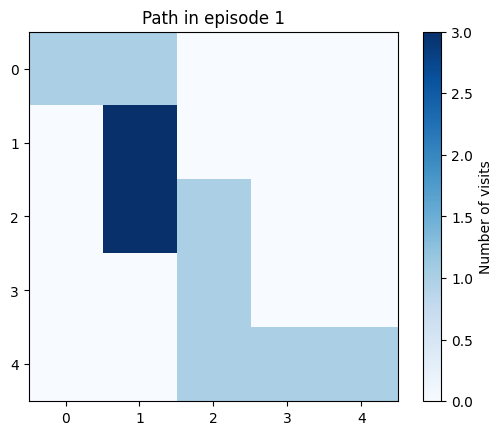

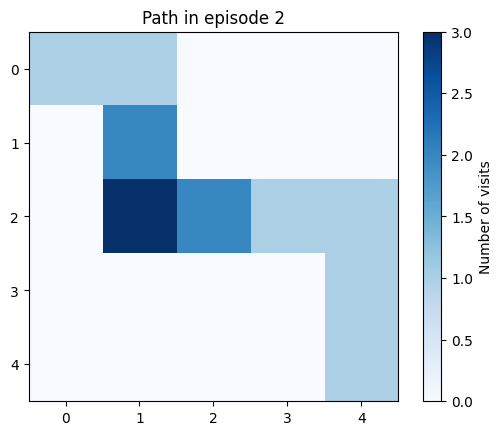

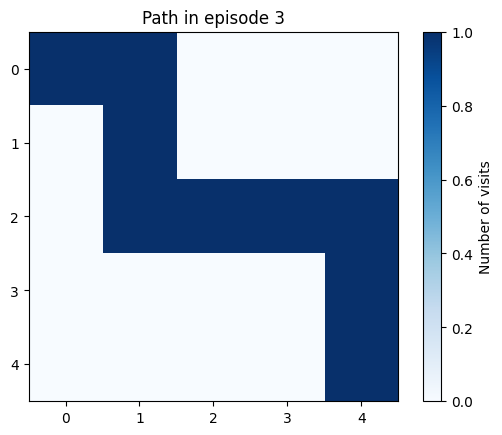

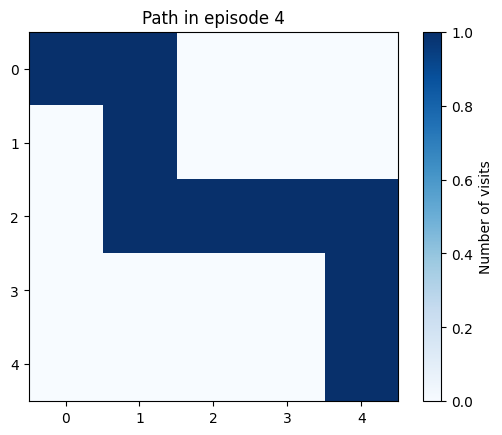

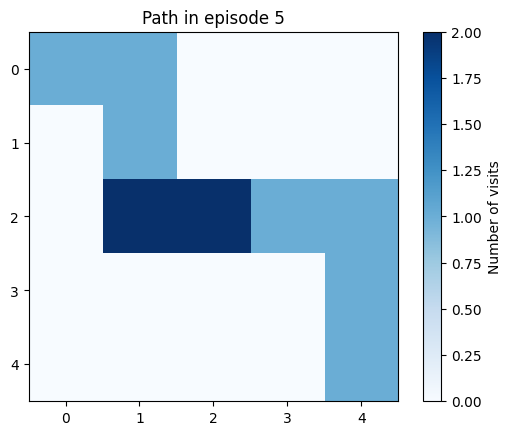

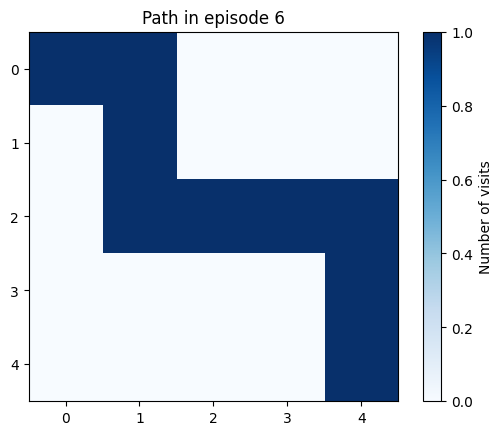

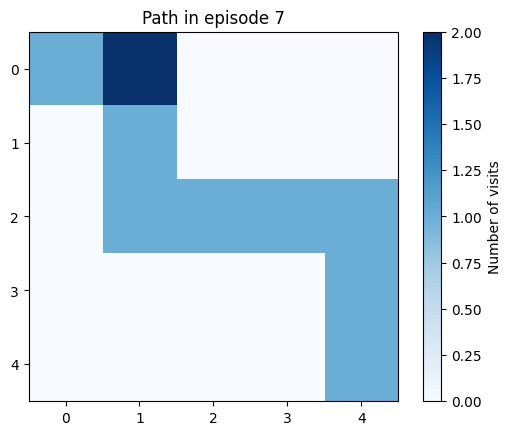

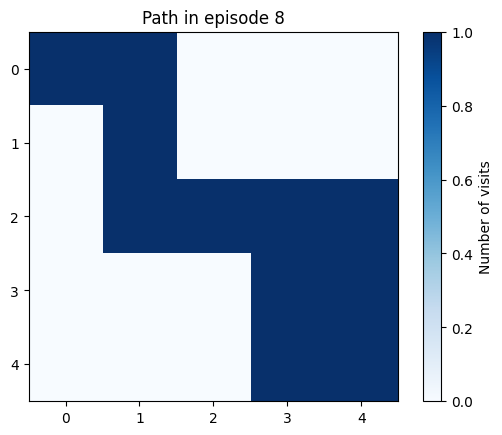

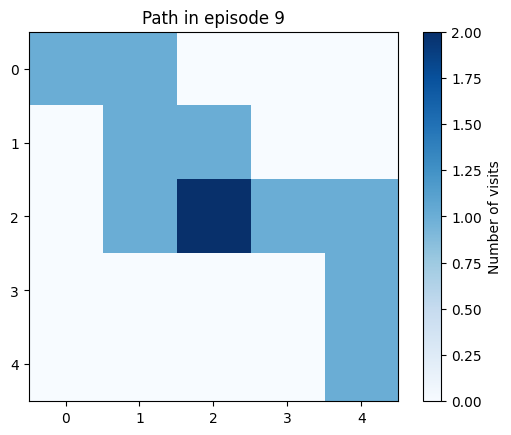

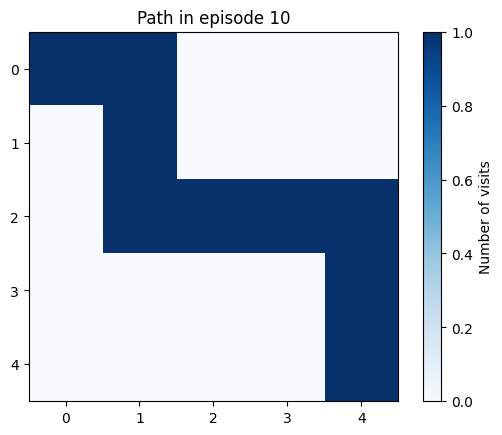

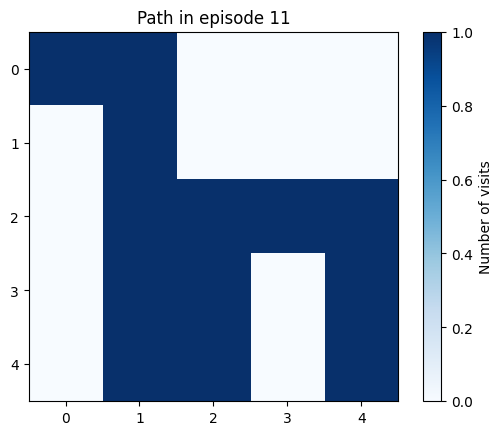

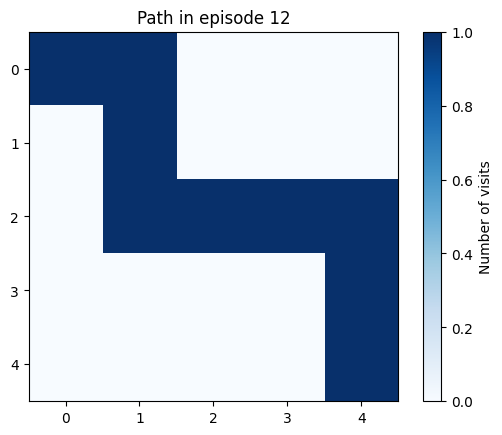

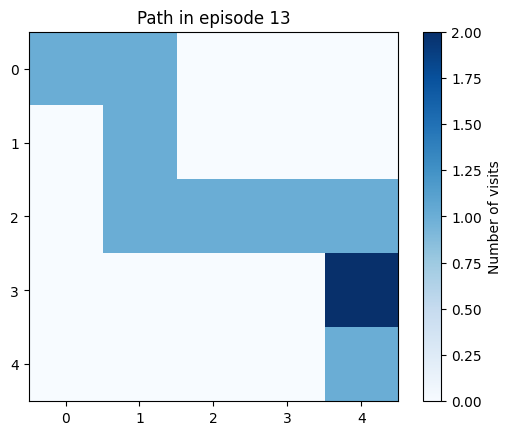

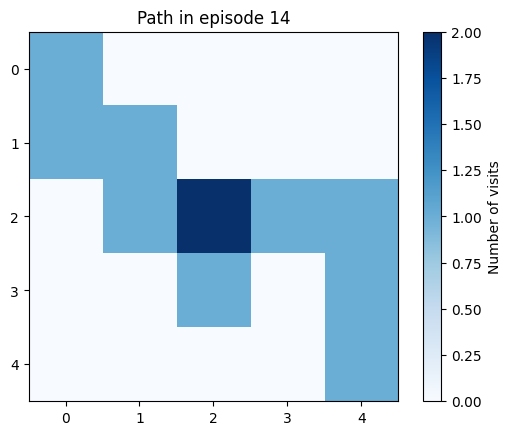

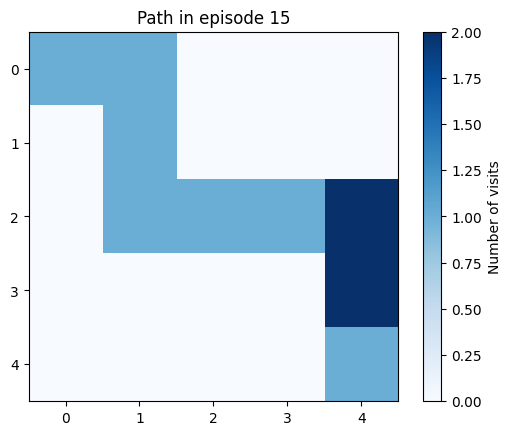

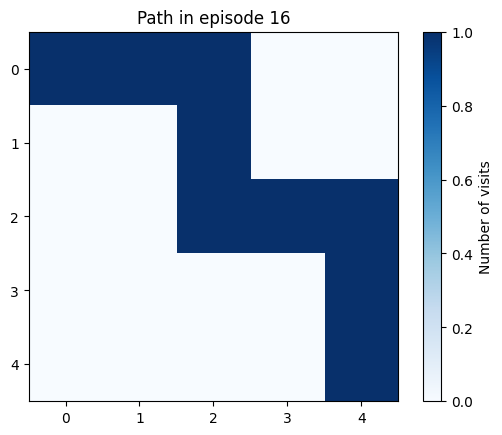

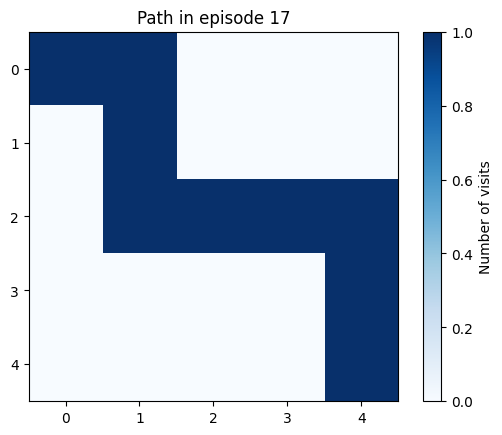

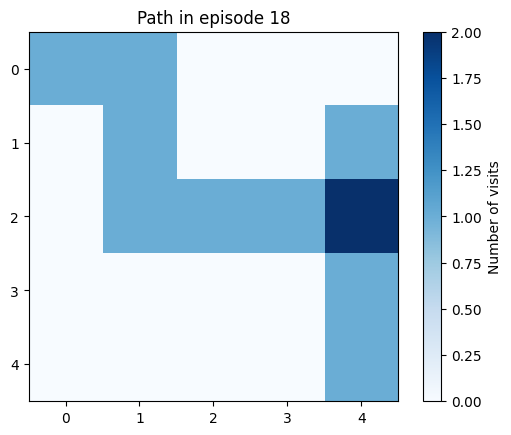

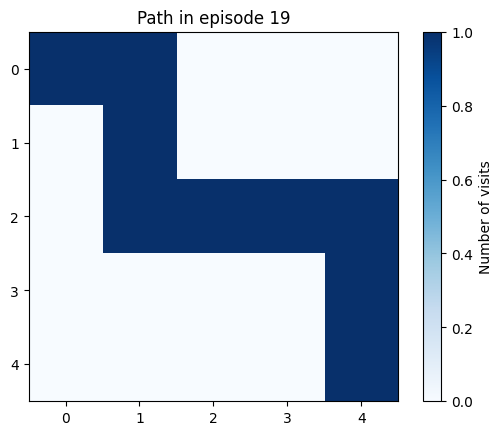

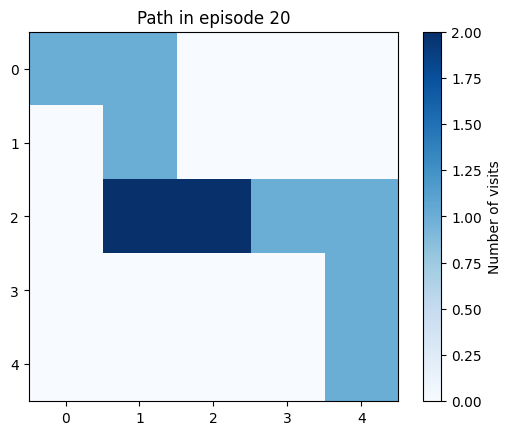

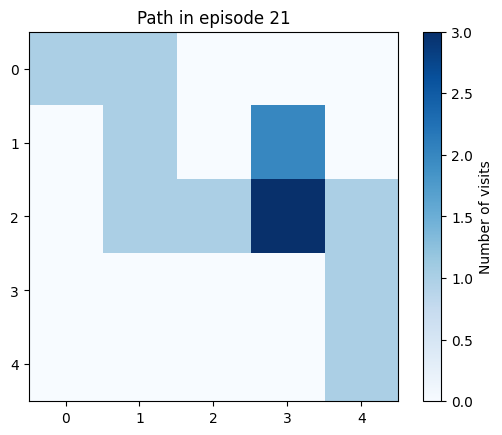

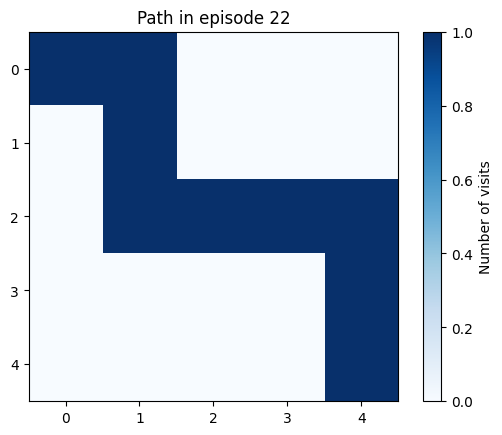

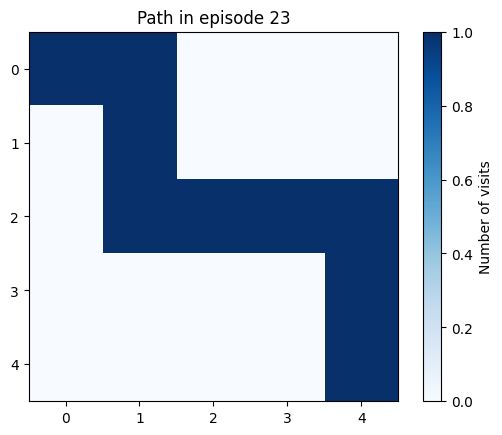

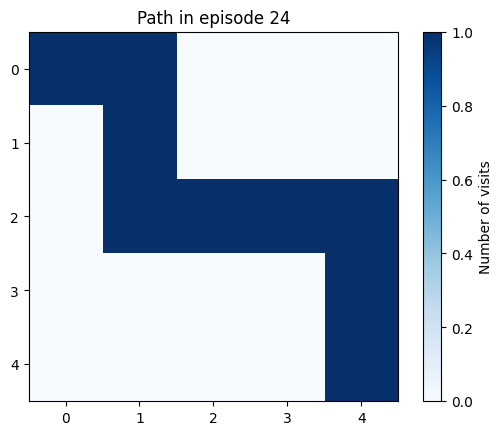

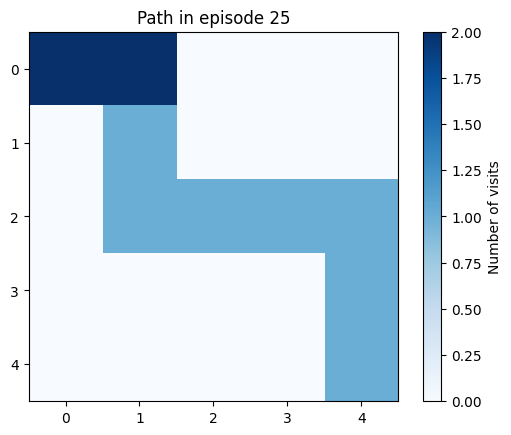

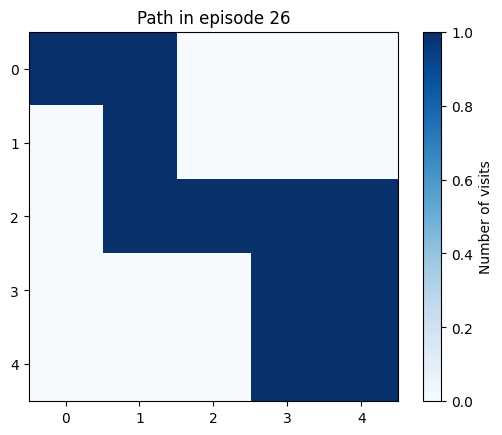

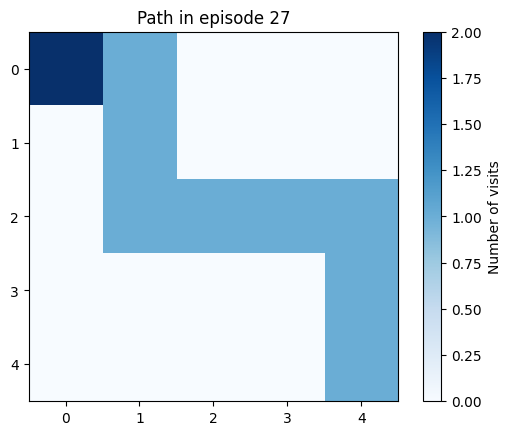

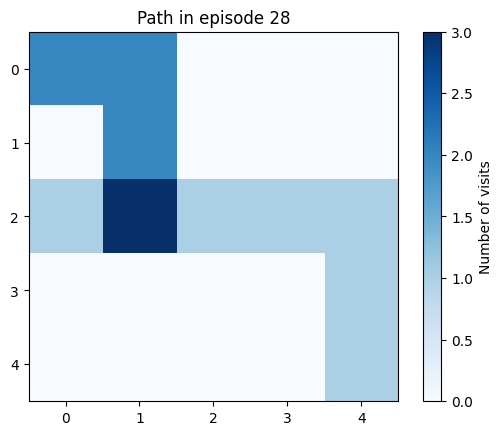

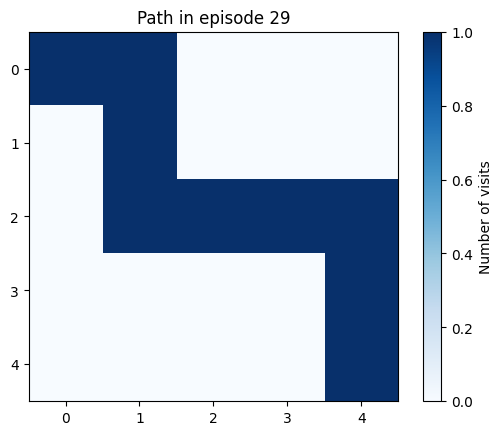

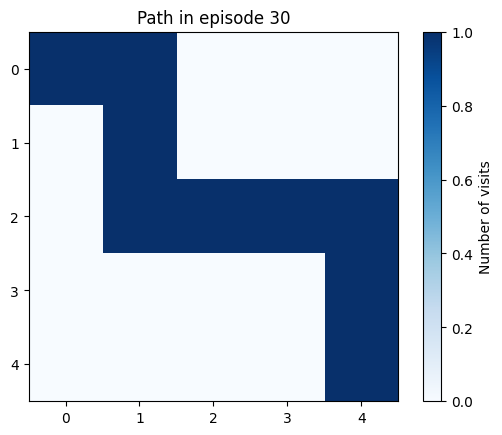

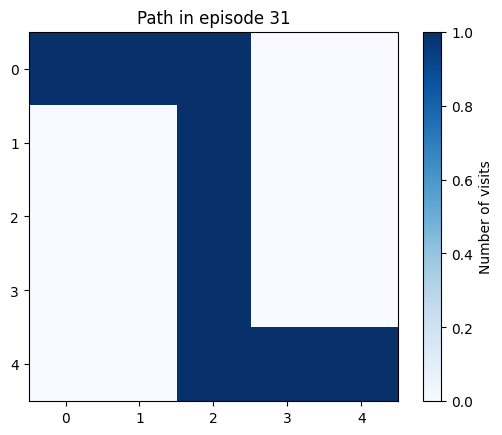

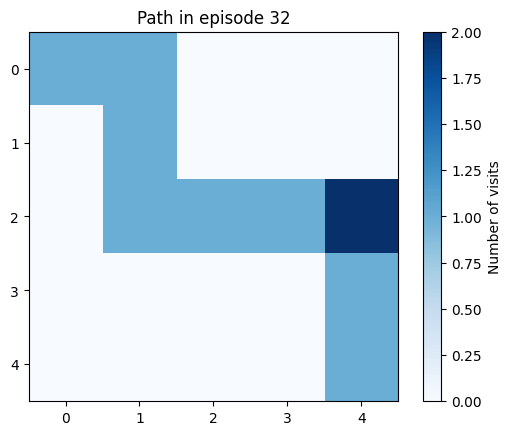

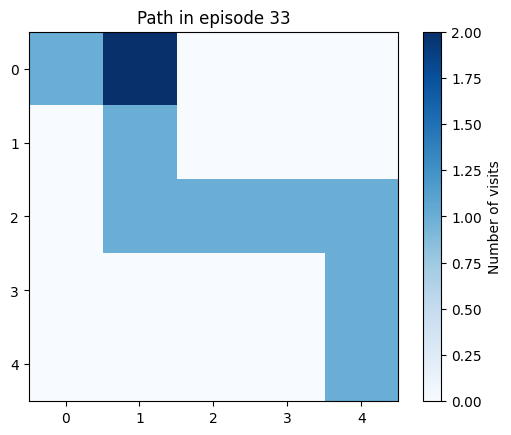

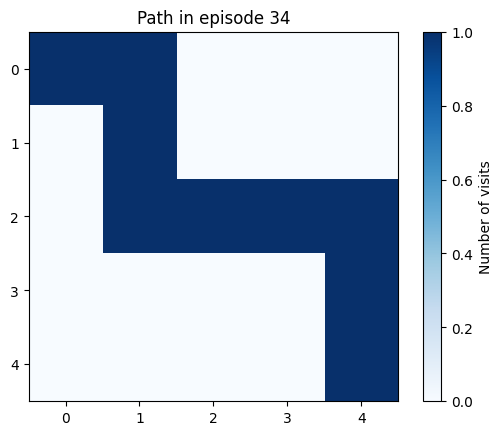

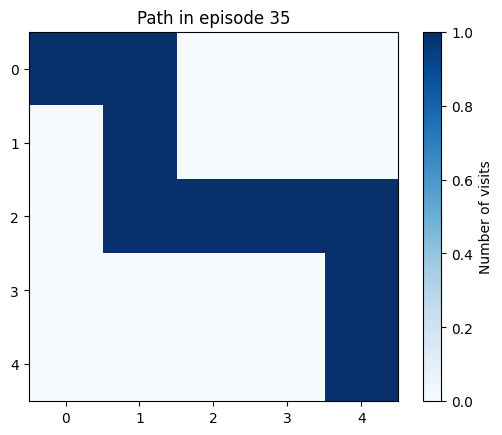

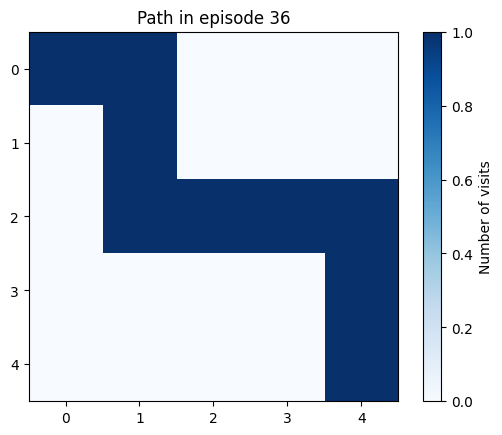

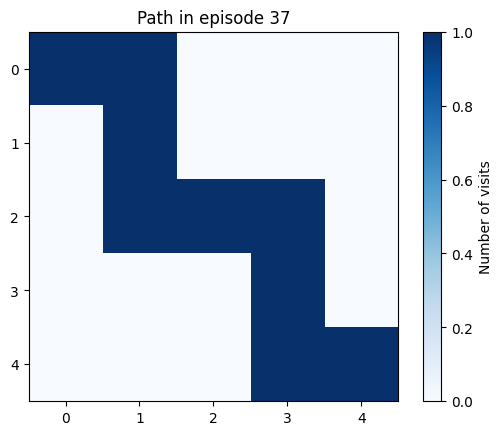

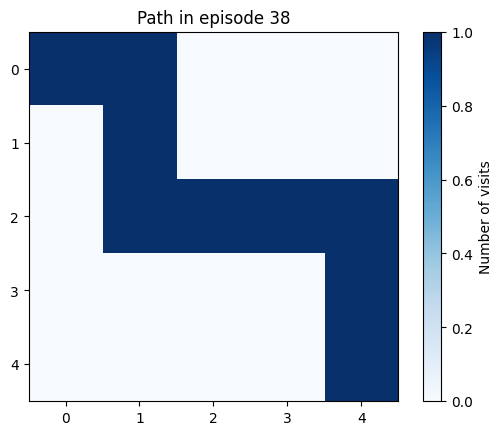

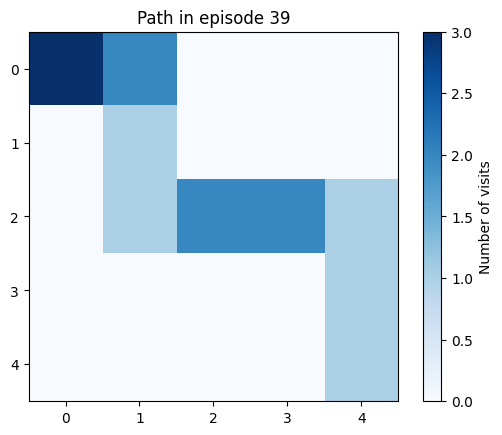

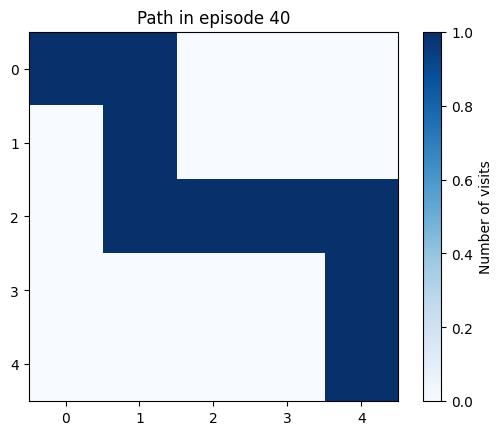

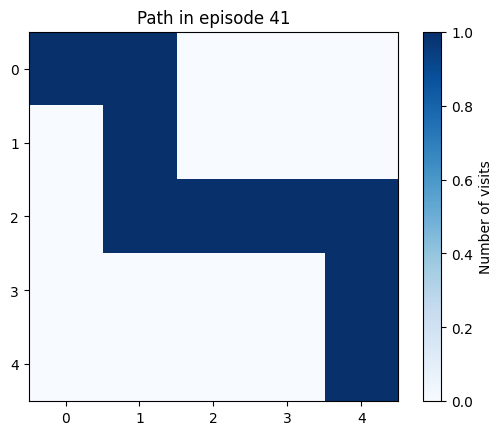

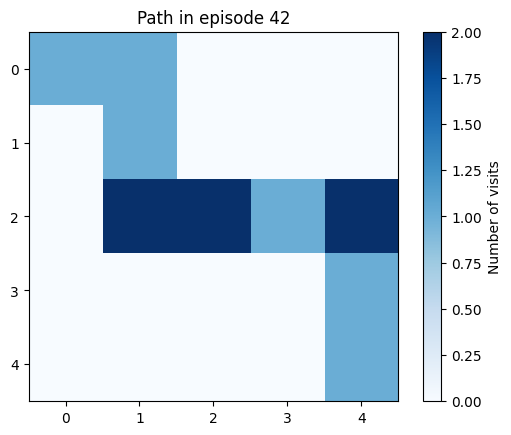

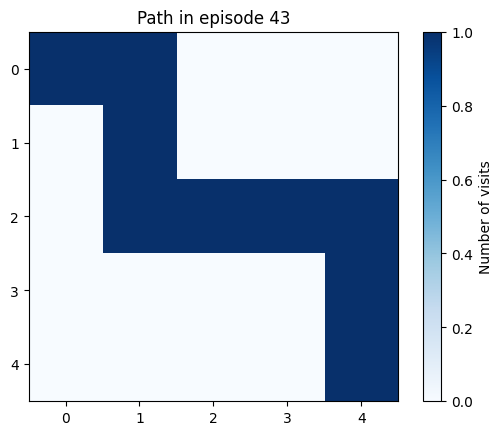

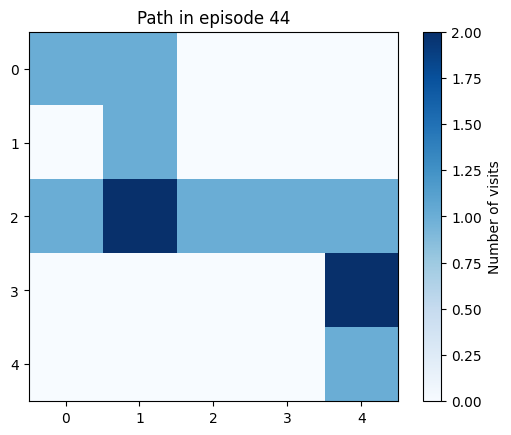

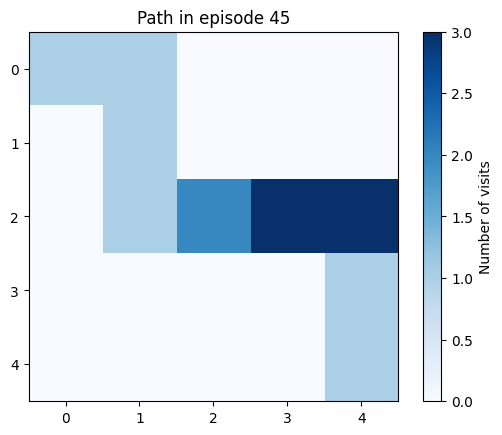

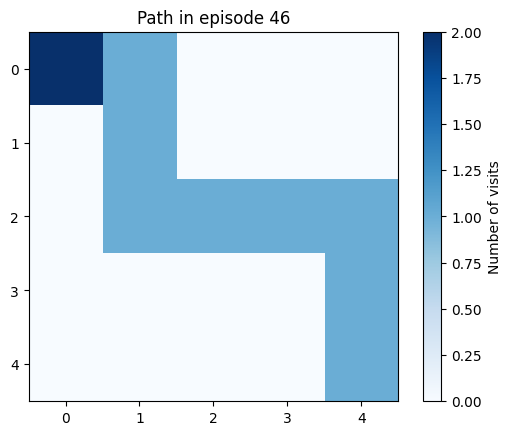

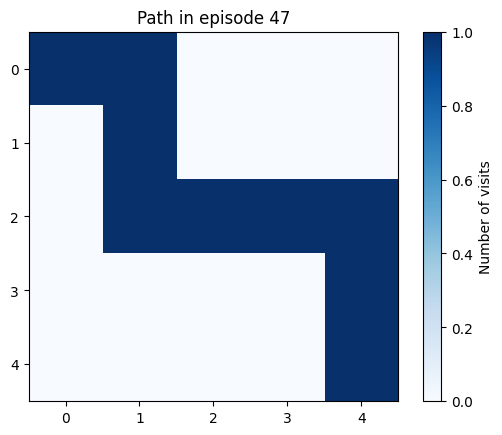

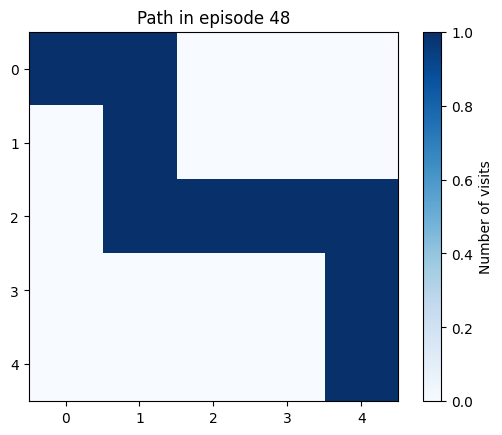

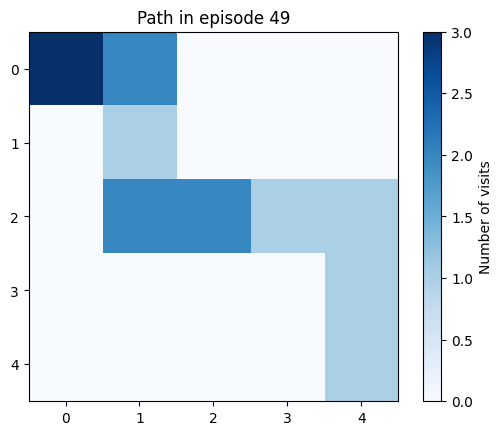

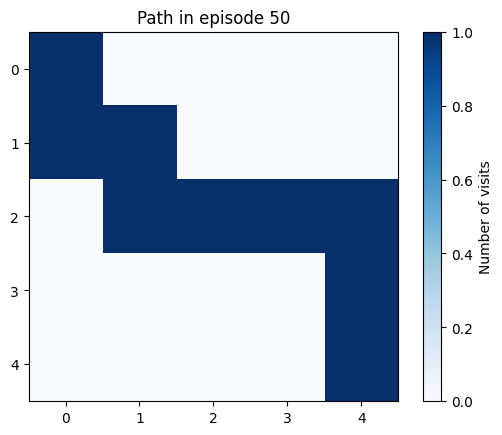

In [10]:
# Visualize the agent's path for a few episodes
visualize_agent(env, agent, episodes=50)

## Metrics to Evaluate Model Performance

To evaluate how well the Q-learning agent is performing, we use several metrics that provide insights into its learning process and effectiveness:

1. **Average Steps to Complete the Task**: Measures the average number of steps the agent takes to complete the task. Fewer steps indicate better learning.

2. **Success Rate**: The percentage of trials in which the agent successfully completes the task. A higher success rate means the agent is reliably achieving its goal.

3. **Convergence of Q-values**: Tracks how Q-values for specific state-action pairs stabilize over time, indicating the agent has learned a consistent policy.

4. **Path Efficiency**: Analyzes how often the agent takes the shortest possible path to complete the task. Higher efficiency reflects better decision-making.

5. **Exploration vs. Exploitation Rate**: Monitors the balance between the agent exploring new actions and exploiting known actions to maximize rewards.

These metrics help us assess the overall performance and robustness of the Q-learning agent.

# Metrics to Evaluate Model Performance

Average steps taken: 9.12
Average steps taken to complete the task: 9.12
Success rate: 100.0%


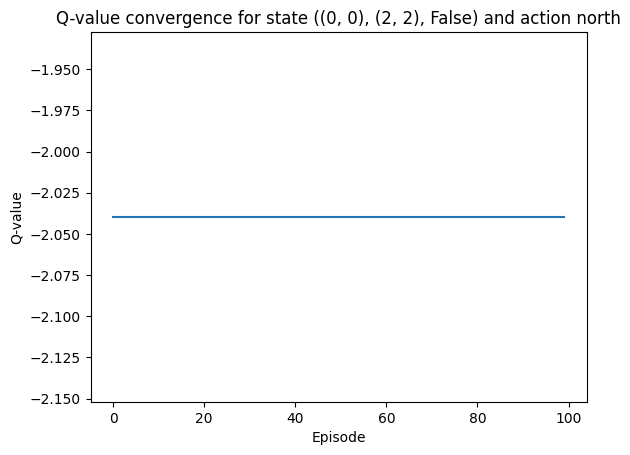

Path efficiency: 67.0%
Exploration rate: 10.229992715162869%
Exploitation rate: 89.77000728483713%


In [11]:
average_steps = test_agent(agent, env, trials=100)
print(f"Average steps taken to complete the task: {average_steps}")

def success_rate(agent, environment, trials=100):
    successful_trials = 0
    for trial in range(trials):
        state = environment.reset()
        done = False
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
        if state[0] == environment.goal_location and environment.has_item:
            successful_trials += 1
    return successful_trials / trials * 100

success_rate_percentage = success_rate(agent, env, trials=100)
print(f"Success rate: {success_rate_percentage}%")

def q_value_convergence(agent, state, action):
    q_values = []
    for _ in range(100):
        q_values.append(agent.get_q_value(state, action))
    plt.plot(q_values)
    plt.title(f'Q-value convergence for state {state} and action {action}')
    plt.xlabel('Episode')
    plt.ylabel('Q-value')
    plt.show()

# Example of checking Q-value convergence for a specific state-action pair
q_value_convergence(agent, state=((0, 0), (2, 2), False), action='north')

def path_efficiency(agent, environment, trials=100):
    optimal_steps = 8  # Example: optimal path length in a 5x5 grid
    efficient_paths = 0
    for trial in range(trials):
        state = environment.reset()
        done = False
        steps = 0
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
            steps += 1
        if steps == optimal_steps:
            efficient_paths += 1
    return efficient_paths / trials * 100

efficiency_percentage = path_efficiency(agent, env, trials=100)
print(f"Path efficiency: {efficiency_percentage}%")

def exploration_exploitation_rate(agent, environment, episodes=1000):
    exploration_count = 0
    exploitation_count = 0
    for episode in range(episodes):
        state = environment.reset()
        done = False
        while not done:
            if random.uniform(0, 1) < agent.epsilon:
                exploration_count += 1
            else:
                exploitation_count += 1
            action = agent.choose_action(state)
            next_state, reward, done = environment.step(action)
            state = next_state
    exploration_rate = exploration_count / (exploration_count + exploitation_count) * 100
    exploitation_rate = exploitation_count / (exploration_count + exploitation_count) * 100
    return exploration_rate, exploitation_rate

exploration_rate, exploitation_rate = exploration_exploitation_rate(agent, env)
print(f"Exploration rate: {exploration_rate}%")
print(f"Exploitation rate: {exploitation_rate}%")

